# Model A

**Input data**

CMEMS wave data (Significant Maximum Wave Height VCMX)

Time: 01/01/2015 - 31/12/2021 (Dec-Mar)

Training period: 01/12/2015 - 07/03/2020

Testing period: 01/12/2020 - 31/03/2021

Region: Nazaré (39.7°–39.5°N, −9.3° to −9.05°E)

Sequence-to-one on a rolling window with three continuous time steps as input and one timestep as output over various forecasting lead times across 24 hours.

## Set parameters

In [128]:
forecast_steps = 24 # to be changed accordingly every model run

In [129]:
input_steps = 3 

kernel_input1 = 3
kernel_input2 = 3
batch_input = 16
regulizer = 0.0001
run_id = forecast_steps  


In [130]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers


### STEP 1: Load and preprocess CMEMS wave data

In [131]:
# Process data for period of interest over 6 years

# Set working directory
os.chdir('C:/Users/filot/OneDrive - University of Strathclyde/Diss')
ds = xr.open_dataset("data/part9.nc")

# Define months of interest
months_of_interest = [1, 2, 3, 12]

# Filter dataset
filtered_ds = ds.sel(time=ds['time'].dt.month.isin(months_of_interest))

# Extract Hmax
hs = filtered_ds['VCMX']  # (time, lat, lon)

print(hs.shape)

(17472, 8, 9)


In [132]:
#fill nan with zeros for land data
hs_filled = hs.fillna(0)

# Normalize using Z-score normalization or standardization.
mean_hs = hs_filled.mean().values
std_hs = hs_filled.std().values
hs_norm = (hs_filled - mean_hs) / std_hs

# Convert to NumPy (transpose to time, lat, lon)
data = hs_norm.transpose('time', 'latitude', 'longitude').values

In [133]:
print(data.shape)

(17472, 8, 9)


### STEP 2: Create sequence-to-one training samples

In [134]:
def create_forecast_at_step_dataset(data, input_steps, forecast_steps, stride=1):
    X, y = [], []
    for t in range(0, len(data) - input_steps - forecast_steps + 1, stride):
        X.append(data[t : t + input_steps])  # 3 past time steps
        y.append(data[t + input_steps + forecast_steps - 1])  # specific future step
    X = np.array(X)[..., np.newaxis]  # Add channel dim
    y = np.array(y)[..., np.newaxis]  # Add channel dim
    return X, y
    
X, y = create_forecast_at_step_dataset(data, input_steps=3, forecast_steps=forecast_steps)
print("X:", X.shape, "y:", y.shape)

X: (17446, 3, 8, 9, 1) y: (17446, 8, 9, 1)


### STEP 3: Split into training and test sets

In [135]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### STEP 4: Define Conv-LSTM model

In [136]:
model = Sequential()

model.add(Input(shape=(input_steps, 8, 9, 1)))  

# Layer 1
model.add(ConvLSTM2D(
    filters=64,
    kernel_size=(kernel_input1, kernel_input2),
    padding='same',
    return_sequences=True,
    kernel_regularizer=regularizers.l2(regulizer)
))
model.add(LayerNormalization())

# Layer 2
model.add(ConvLSTM2D(
    filters=32,
    kernel_size=(kernel_input1, kernel_input2),
    padding='same',
    return_sequences=True,
    kernel_regularizer=regularizers.l2(regulizer)
))
model.add(LayerNormalization())

# Layer 3
model.add(ConvLSTM2D(
    filters=16,
    kernel_size=(kernel_input1, kernel_input2),
    padding='same',
    return_sequences=True,
    kernel_regularizer=regularizers.l2(regulizer)
))
model.add(LayerNormalization())

# Layer 4
model.add(ConvLSTM2D(
    filters=16,
    kernel_size=(kernel_input1, kernel_input2),
    padding='same',
    return_sequences=False,
    kernel_regularizer=regularizers.l2(regulizer)
))
model.add(LayerNormalization())

# Final Output Layer (Paper uses Conv2D per time step)
model.add(Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation='linear',
    padding='same',
    kernel_regularizer=regularizers.l2(regulizer)
))


model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_34 (ConvLSTM2D)          │ (None, 3, 8, 9, 64)         │         150,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_34               │ (None, 3, 8, 9, 64)         │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_35 (ConvLSTM2D)          │ (None, 3, 8, 9, 32)         │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_35               │ (None, 3, 8, 9, 32)         │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_36 (ConvLSTM2D)          │ (None, 3, 8, 9, 16)         │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_36               │ (None, 3, 8, 9, 16)         │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_37 (ConvLSTM2D)          │ (None, 8, 9, 16)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_37               │ (None, 8, 9, 16)            │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 9, 1)             │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,217 (1.17 MB)

 Trainable params: 307,217 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

### STEP 5: Train the model

In [137]:

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=batch_input,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step - loss: 0.4535 - mae: 0.4752 - val_loss: 0.3724 - val_mae: 0.4124
Epoch 2/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 0.3621 - mae: 0.4171 - val_loss: 0.3001 - val_mae: 0.3847
Epoch 3/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 0.3409 - mae: 0.4022 - val_loss: 0.3050 - val_mae: 0.3996
Epoch 4/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - loss: 0.3207 - mae: 0.3889 - val_loss: 0.3327 - val_mae: 0.3949
Epoch 5/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.3257 - mae: 0.3888 - val_loss: 0.3118 - val_mae: 0.4118
Epoch 6/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.3240 - mae: 0.3918 - val_loss: 0.3114 - val_mae: 0.4032
Epoch 7/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.3183 - mae: 0.3869 - val_loss: 0.2972 - val_mae: 0.3775
Epoch 8/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - loss: 0.3190 - mae: 0.3882 - val_loss: 0.3060 - val_mae: 0.3973
Epoch 9/40
698/698 ━━━━━━━━━━━━━━━━━━━━ 

In [138]:
model.save(f'results/model_A/saved_model/{run_id}_model.keras')


## Step 6: Evaluating results

### Evaluating training performace

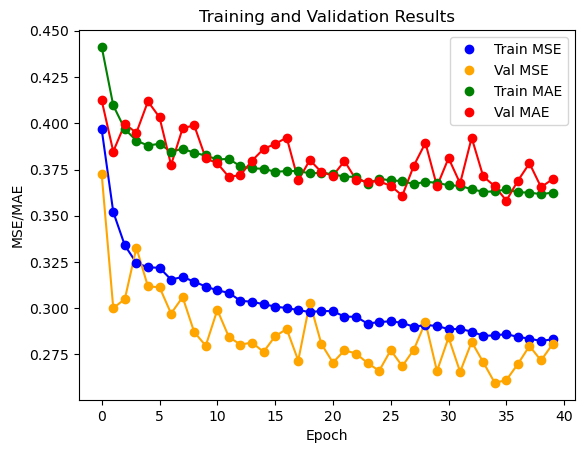

In [139]:
# Define number of epochs
epochs = range(len(history.history['loss']))

# Plot grey lines (shared for all metrics)
plt.plot(epochs, history.history['loss'], color='blue', linestyle='-')
plt.plot(epochs, history.history['val_loss'], color='orange', linestyle='-')
plt.plot(epochs, history.history['mae'], color='green', linestyle='-')
plt.plot(epochs, history.history['val_mae'], color='red', linestyle='-')

# Overlay colored circle markers
plt.plot(epochs, history.history['loss'], marker='o', linestyle='None', label='Train MSE', color='blue')
plt.plot(epochs, history.history['val_loss'], marker='o', linestyle='None', label='Val MSE', color='orange')
plt.plot(epochs, history.history['mae'], marker='o', linestyle='None', label='Train MAE', color='green')
plt.plot(epochs, history.history['val_mae'], marker='o', linestyle='None', label='Val MAE', color='red')

plt.xlabel('Epoch')
plt.ylabel('MSE/MAE')
plt.legend()
plt.grid(False)
plt.title("Training and Validation Results")
plt.savefig(f"results/model_A/training_history/training_history_plot_{run_id}.png", dpi=300)
plt.show()


### Saving training + validation loss/MAE

In [140]:
# Create a DataFrame from the history
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv(f'results/model_A/training_history/training_history_{run_id}.csv', index=False)
